In [1]:
import warnings
import os
import pathlib
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import json
from typing import Dict

from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import XGBoostPruningCallback

from flexitext import flexitext

import mlflow

import lightning.pytorch as pl

warnings.filterwarnings("ignore")

c:\Users\arasyidi\AppData\Local\miniconda3\envs\conda_aqi_forecast\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import xgb_helper, xgb_engine

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
secret_dir = root_dir / "secret"

In [5]:
processed_file_name = f"klhk_usable_linearimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

In [6]:
raw_df = pd.read_csv(processed_file_path)
raw_df.head()

,Unnamed: 0,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time,lin_pm25
0,1992,Bekasi Kayuringin,62.0,96.0,40.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 00:00:00,96.0
1,1993,Bekasi Kayuringin,62.0,97.0,41.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 01:00:00,97.0
2,1994,Bekasi Kayuringin,63.0,97.0,42.0,15.0,45.0,28.0,70.0,55.4,150.4,2023-06-01 02:00:00,97.0
3,1995,Bekasi Kayuringin,63.0,98.0,42.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 03:00:00,98.0
4,1996,Bekasi Kayuringin,62.0,97.0,43.0,15.0,45.0,29.0,70.0,55.4,150.4,2023-06-01 04:00:00,97.0


In [7]:
stasiun_name = 'Bekasi Kayuringin'

In [8]:
filtered_df = raw_df[raw_df['stasiun'] == stasiun_name][['read_time','lin_pm25']]

# Make sure that you have the correct order of the times
filtered_df['read_time'] = pd.to_datetime(filtered_df['read_time'])
filtered_df = filtered_df.sort_values(by='read_time', ascending=True)

# Set Datetime as index
filtered_df = filtered_df.set_index(['read_time'])

# # convert to log return
# period = 168
# df_logret = np.log(filtered_df).diff(period)
# df_logret.dropna(inplace=True)

In [9]:
# Define the proportions for train, validation, and test sets
train_frac = 0.6  # 60% of the data for training
val_frac = 0.2    # 20% for validation
test_frac = 0.2   # 20% for testing

df_train, df_val, df_test = xgb_helper.xgb_time_train_test_split(
    filtered_df,
    train_frac,
    val_frac,
    test_frac
)

length of train: 1382 | 60% of total length
length of validation: 460 | 20% of total length
length of test: 462 | 20% of total length


In [10]:
train_x, train_y = xgb_helper.create_features(df_train, target_variable='lin_pm25')
val_x, val_y = xgb_helper.create_features(df_val, target_variable='lin_pm25')
test_x, test_y = xgb_helper.create_features(df_test, target_variable='lin_pm25')

In [14]:
temp = pd.DataFrame(val_y)
temp['pred'] = 100

In [15]:
temp.head()

,lin_pm25,pred
read_time,,
2023-07-28 14:00:00,111.0,100
2023-07-28 15:00:00,108.0,100
2023-07-28 16:00:00,106.0,100
2023-07-28 17:00:00,105.0,100
2023-07-28 18:00:00,106.0,100


In [16]:
# Calculate the squared differences
temp['squared_diff'] = (temp['lin_pm25'] - temp['pred'])**2

# Calculate the mean of the squared differences
mse = temp['squared_diff'].mean()

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 15.276651693238337


<Axes: xlabel='read_time'>

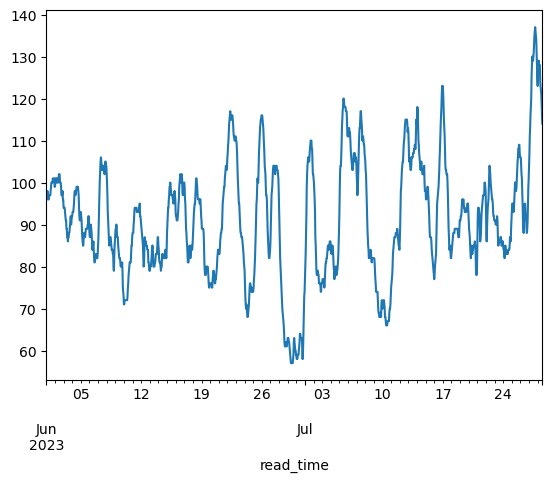

In [25]:
train_y.plot.line()

<Axes: xlabel='read_time'>

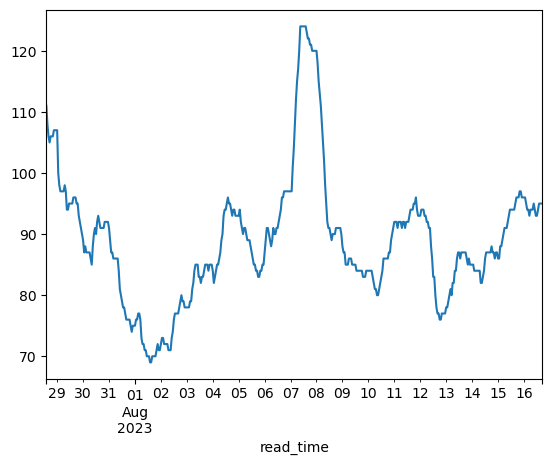

In [24]:
val_y.plot.line()

<Axes: xlabel='read_time'>

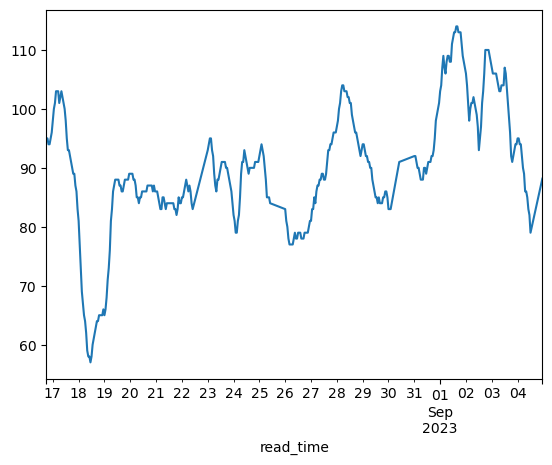

In [26]:
test_y.plot.line()

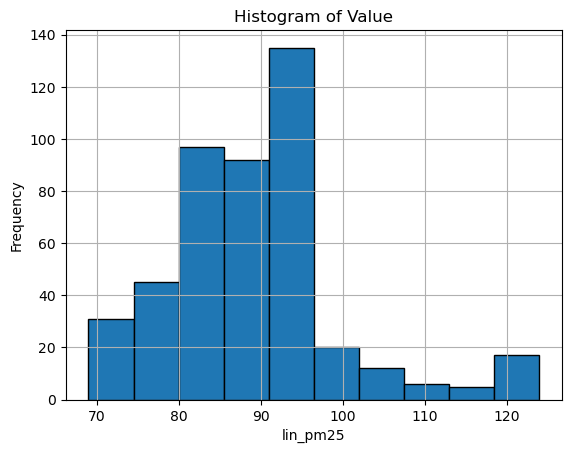

In [17]:
# Create a histogram
plt.hist(temp['lin_pm25'], bins=10, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('lin_pm25')
plt.ylabel('Frequency')
plt.title('Histogram of Value')
plt.grid(True)